In [1]:
%load_ext autoreload
%autoreload 2

from IPython import get_ipython
IS_COLAB_ENV = 'google.colab' in str(get_ipython())

if IS_COLAB_ENV:
    ! pip install -qq matchms numba joblib
    ! mkdir -p data/input && cd data/input && wget -q https://storage.googleapis.com/tornikeo-tmp-io/example_dataset_tornike.csv
else:
    from nbutils import chdir_to_root
    chdir_to_root()
%pwd

'/home/tornikeo/Documents/work/scalexa/pangeaai/optimize-cosine'

In [2]:
from cudams.utils import argbatch, mkdir
from cudams.data import get_ref_spectra_from_df
from cudams.kernel import compile
from cudams.utils import name2idx
from cudams.cosine import similarity
import math
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from cudams.data import spectra_peaks_to_tensor
from cudams.processor import Config
from numba import cuda
from itertools import product
from time import perf_counter
from multiprocessing.pool import ThreadPool
from multiprocessing import shared_memory
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
from typing import Tuple
from matchms.typing import SpectrumType
from matchms.similarity.BaseSimilarity import BaseSimilarity
from matchms.similarity.spectrum_similarity_functions import (collect_peak_pairs,
                                            score_best_matches)
from matchms.similarity import CosineGreedy as OriginalCosineGreedy

assert cuda.is_available()

In [3]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

# MAX NUMBER OF PEAKS 
MAX_PEAKS = 1024

# Data path
reference_csv_file = Path("data/input/test_set_cosine.csv")
query_csv_file = Path("data/input/test_set_cosine.csv")

In [4]:
from matchms import calculate_scores
from tqdm import tqdm
from matchms.filtering import normalize_intensities, select_by_mz, select_by_relative_intensity, reduce_to_number_of_peaks, \
    require_minimum_number_of_peaks

def process_spectrum(spectrum: np.ndarray) -> np.ndarray:
    # spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
    # spectrum = normalize_intensities(spectrum)
    # spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    # spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=MAX_PEAKS)
    # spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
    return spectrum

ref_spectra_df_path = Path(reference_csv_file)
ref_spectra_df = pd.read_csv(ref_spectra_df_path)
references = get_ref_spectra_from_df(ref_spectra_df, 
                                    spectrum_processor=process_spectrum,
                                    limit=256,)

query_spectra_df_path = Path(query_csv_file)
query_spectra_df = pd.read_csv(query_spectra_df_path)
queries = get_ref_spectra_from_df(query_spectra_df, 
                                spectrum_processor=process_spectrum,
                                limit=256,)

100%|██████████| 256/256 [00:00<00:00, 2445.36it/s]


In [5]:
import matchms.similarity.CosineGreedy as OriginalCosineGreedy

class CosineGreedy(OriginalCosineGreedy):
    """Stable implementation of original cosine greedy"""
    def __init__(self, tolerance: float = 0.1, mz_power: float = 0, intensity_power: float = 1):
        super().__init__(tolerance, mz_power, intensity_power)
        
    def pair(self, reference: SpectrumType, query: SpectrumType) -> Tuple[float, int]:
        """Calculate cosine score between two spectra.

        Parameters
        ----------
        reference
            Single reference spectrum.
        query
            Single query spectrum.

        Returns
        -------
        Score
            Tuple with cosine score and number of matched peaks.
        """
        def get_matching_pairs():
            """Get pairs of peaks that match within the given tolerance."""
            matching_pairs = collect_peak_pairs(spec1, spec2, self.tolerance,
                                                shift=0.0, mz_power=self.mz_power,
                                                intensity_power=self.intensity_power)
            if matching_pairs is None:
                return None
            # This is the only argument that we change `kind='mergesort'`
            matching_pairs = matching_pairs[np.argsort(matching_pairs[:, 2],kind='mergesort')[::-1], :]
            return matching_pairs

        spec1 = reference.peaks.to_numpy
        spec2 = query.peaks.to_numpy
        matching_pairs = get_matching_pairs()
        if matching_pairs is None:
            return np.asarray((float(0), 0), dtype=self.score_datatype)
        score = score_best_matches(matching_pairs, spec1, spec2,
                                   self.mz_power, self.intensity_power)
        return np.asarray(score, dtype=self.score_datatype)


tolerances = np.linspace(.01, .2, 10)

pairs_per_hr_mergesort = []
for tolerance in tqdm(tolerances):
    similarity_measure = CosineGreedy(tolerance=tolerance, 
                                    mz_power=mz_power, 
                                    intensity_power=int_power)
    duration = -perf_counter()
    scores = calculate_scores(references, queries, similarity_measure, is_symmetric=False)
    duration += perf_counter()
    
    n_pairs = len(references) * len(queries)
    pair_per_hr = (n_pairs / duration) * 3600
    
    pairs_per_hr_mergesort.append(pair_per_hr)

100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


In [7]:
from matchms.similarity import CosineGreedy

similarity_measure = CosineGreedy(tolerance=tolerance, 
                                mz_power= 0.0, 
                                intensity_power = 1.0)

durations_quicksort = []
pairs_per_hr_quicksort = []
for tolerance in tqdm(tolerances):
    similarity_measure = CosineGreedy(tolerance=tolerance, 
                                    mz_power=mz_power, 
                                    intensity_power=int_power)

    duration = -perf_counter()
    scores = calculate_scores(references, queries, similarity_measure, is_symmetric=False)
    duration += perf_counter()
    
    n_pairs = len(references) * len(queries)
    pair_per_hr = (n_pairs / duration) * 3600
    
    pairs_per_hr_quicksort.append(pair_per_hr)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


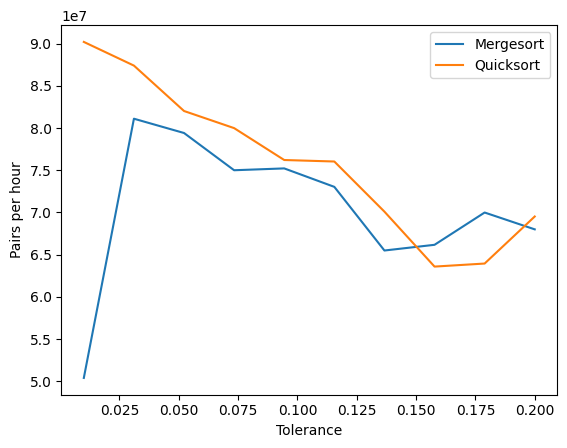

In [17]:
plt.plot(tolerances, pairs_per_hr_mergesort, tolerances, pairs_per_hr_quicksort)
plt.xlabel('Tolerance')
plt.ylabel('Pairs per hour')
plt.legend(["Mergesort",'Quicksort'])

In [19]:

import matchms.similarity.CosineGreedy as OriginalCosineGreedy

class CosineGreedy(OriginalCosineGreedy):
    """Stable implementation of original cosine greedy"""
    def __init__(self, tolerance: float = 0.1, mz_power: float = 0, intensity_power: float = 1):
        super().__init__(tolerance, mz_power, intensity_power)
        
    def pair(self, reference: SpectrumType, query: SpectrumType) -> Tuple[float, int]:
        """Calculate cosine score between two spectra.

        Parameters
        ----------
        reference
            Single reference spectrum.
        query
            Single query spectrum.

        Returns
        -------
        Score
            Tuple with cosine score and number of matched peaks.
        """
        def get_matching_pairs():
            """Get pairs of peaks that match within the given tolerance."""
            matching_pairs = collect_peak_pairs(spec1, spec2, self.tolerance,
                                                shift=0.0, mz_power=self.mz_power,
                                                intensity_power=self.intensity_power)
            if matching_pairs is None:
                return None
            # This is the only argument that we change `kind='mergesort'`
            matching_pairs = matching_pairs[np.argsort(matching_pairs[:, 2],kind='mergesort')[::-1], :]
            return matching_pairs

        spec1 = reference.peaks.to_numpy
        spec2 = query.peaks.to_numpy
        matching_pairs = get_matching_pairs()
        if matching_pairs is None:
            return np.asarray((float(0), 0), dtype=self.score_datatype)
        score = score_best_matches(matching_pairs, spec1, spec2,
                                   self.mz_power, self.intensity_power)
        return np.asarray(score, dtype=self.score_datatype)


tolerance = .1
max_peaks = np.linspace(64, 1024, 10, dtype='int32')

pairs_per_hr_mergesort = []
for MAX_PEAKS in tqdm(max_peaks):
    def process_spectrum(spectrum: np.ndarray) -> np.ndarray:
        # spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
        # spectrum = normalize_intensities(spectrum)
        # spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
        # spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
        spectrum = reduce_to_number_of_peaks(spectrum, n_max=MAX_PEAKS)
        # spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
        return spectrum

    ref_spectra_df_path = Path(reference_csv_file)
    ref_spectra_df = pd.read_csv(ref_spectra_df_path)
    references = get_ref_spectra_from_df(ref_spectra_df, 
                                        spectrum_processor=process_spectrum,
                                        limit=256,)

    query_spectra_df_path = Path(query_csv_file)
    query_spectra_df = pd.read_csv(query_spectra_df_path)
    queries = get_ref_spectra_from_df(query_spectra_df, 
                                    spectrum_processor=process_spectrum,
                                    limit=256,)
    
    similarity_measure = CosineGreedy(tolerance=.1, 
                                    mz_power=mz_power, 
                                    intensity_power=int_power)
    duration = -perf_counter()
    scores = calculate_scores(references, queries, similarity_measure, is_symmetric=False)
    duration += perf_counter()
    
    n_pairs = len(references) * len(queries)
    pair_per_hr = (n_pairs / duration) * 3600
    
    pairs_per_hr_mergesort.append(pair_per_hr)

from matchms.similarity import CosineGreedy
similarity_measure = CosineGreedy(tolerance=tolerance, 
                                mz_power= 0.0, 
                                intensity_power = 1.0)

durations_quicksort = []
pairs_per_hr_quicksort = []

for MAX_PEAKS in tqdm(max_peaks):
    def process_spectrum(spectrum: np.ndarray) -> np.ndarray:
        # spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
        # spectrum = normalize_intensities(spectrum)
        # spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
        # spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
        spectrum = reduce_to_number_of_peaks(spectrum, n_max=MAX_PEAKS)
        # spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
        return spectrum

    ref_spectra_df_path = Path(reference_csv_file)
    ref_spectra_df = pd.read_csv(ref_spectra_df_path)
    references = get_ref_spectra_from_df(ref_spectra_df, 
                                        spectrum_processor=process_spectrum,
                                        limit=256,)

    query_spectra_df_path = Path(query_csv_file)
    query_spectra_df = pd.read_csv(query_spectra_df_path)
    queries = get_ref_spectra_from_df(query_spectra_df, 
                                    spectrum_processor=process_spectrum,
                                    limit=256,)
    
    similarity_measure = CosineGreedy(tolerance=tolerance, 
                                    mz_power=mz_power, 
                                    intensity_power=int_power)

    duration = -perf_counter()
    scores = calculate_scores(references, queries, similarity_measure, is_symmetric=False)
    duration += perf_counter()
    
    n_pairs = len(references) * len(queries)
    pair_per_hr = (n_pairs / duration) * 3600
    
    pairs_per_hr_quicksort.append(pair_per_hr)

  0%|          | 0/10 [00:00<?, ?it/s]






100%|██████████| 256/256 [00:02<00:00, 111.31it/s]


 10%|█         | 1/10 [00:05<00:52,  5.86s/it]

100%|██████████| 256/256 [00:00<00:00, 2208.55it/s]


 20%|██        | 2/10 [00:09<00:37,  4.74s/it]

100%|██████████| 256/256 [00:00<00:00, 2398.17it/s]


 30%|███       | 3/10 [00:13<00:30,  4.38s/it]

100%|██████████| 256/256 [00:00<00:00, 2282.46it/s]


 40%|████      | 4/10 [00:17<00:25,  4.31s/it]

100%|██████████| 256/256 [00:00<00:00, 1985.78it/s]


 50%|█████     | 5/10 [00:21<00:20,  4.20s/it]

100%|██████████| 256/256 [00:00<00:00, 2328.60it/s]


 60%|██████    | 6/10 [00:25<00:16,  4.11s/it]

100%|██████████| 256/256 [00:00<00:00, 2243.88it/s]


 70%|███████   | 7/10 [00:29<00:12,  4.10s/it]

100%|██████████| 256/256 [00:00<00:00, 2248.59it/s]


 80%|████████  | 8/10 [00:34<00:08,  4.08s/it]

100%|██████████| 256/256 [00:00<00:00, 2166.96it/s]


 90%|█████████ | 9/10 [00:38<00:04,  4.06s/it]

100%|██████████| 256/256 [00:00<00:00, 2045.42it/s]


  0%|          | 0/10 [0

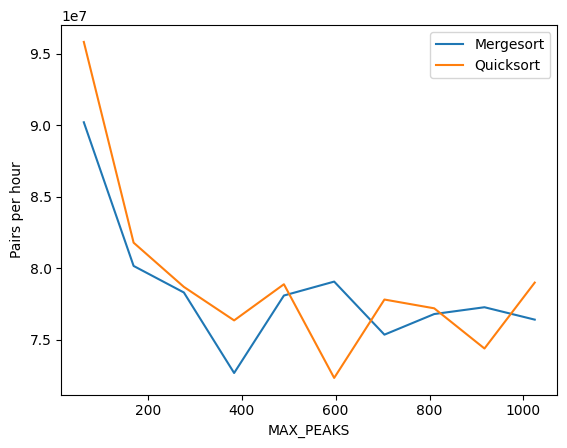

In [20]:
plt.plot(max_peaks, pairs_per_hr_mergesort, max_peaks, pairs_per_hr_quicksort)
plt.xlabel('MAX_PEAKS')
plt.ylabel('Pairs per hour')
plt.legend(["Mergesort",'Quicksort'])